In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, TimeSeriesSplit
from joblib import Parallel, delayed

# TODO: add files from which we import functions
from scripts import (
    load_joined_data,
    split_data,
    cap_outliers,
    remove_seasonality_ia,
    restore_seasonality_ia,
    add_lags,
    evaluate_feature_importance,
    dnn,
    mean_absolute_percentage_error,
    XGBSaveFoldsModels
)

from catboost import CatBoostRegressor, Pool, cv as cat_cv, sum_models
from deepforest import CascadeForestRegressor
from xgboost import XGBRegressor, DMatrix, cv as xgb_cv
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor

START = datetime(2021, 4, 1, 9, 30)
END = datetime(2022, 4, 1, 16, 0)
BUCKET = 600  # seconds

COLUMNS = ["VOLUME_fut", "VOLUME_etf", "VOLUME_opt"]
TARGET = "VOLUME_fut_target"

if not ("REMOVE_SEASONALITY" in locals() or "REMOVE_SEASONALITY" in globals()):
    REMOVE_SEASONALITY = True
if not ("PLOT_CHARTS" in locals() or "PLOT_CHARTS" in globals()):
    PLOT_CHARTS = True
FOLDS_NUM = 10

/home/otestov/code/ml/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-28 16:50:40.204897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-28 16:50:40.204920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ts = load_joined_data(common_kwargs=dict(start=START, end=END, bucket=BUCKET))

In [3]:
# load cached data
ts = load_joined_data(
    pd.read_csv('./data/etf_nq.csv', index_col='Time'),
    pd.read_csv('./data/fut_nq.csv', index_col='Time'),
    pd.read_csv('./data/opt_nq.csv', index_col='Time'),
)
ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967,5787283,20914,940,31967
1,2021-04-01 09:50:00,13194,3001767,14998,950,13194
2,2021-04-01 10:00:00,9774,1523707,9644,1000,9774
3,2021-04-01 10:10:00,26026,3199697,17938,1010,26026
4,2021-04-01 10:20:00,10889,2662730,12092,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872,1283681,18724,1520,8872
9847,2022-03-31 15:30:00,12924,1501646,12523,1530,12924
9848,2022-03-31 15:40:00,16582,1970892,18835,1540,16582
9849,2022-03-31 15:50:00,13761,2629317,15626,1550,13761


# Preparing Data

In [4]:
# split data into training, validation, and test sets (10% each for val and test)
train_indexes, val_indexes, test_indexes = split_data(ts, val_size = 0.1, test_size = 0.1)

# cap outliers to within 4 standard deviations from the mean
ts = cap_outliers(ts, train_indexes, COLUMNS, std_num=4)

# remove seasonality by normalizing based on the intraday average
if REMOVE_SEASONALITY:
    ts = remove_seasonality_ia(ts, COLUMNS, bins=39, window_days=20)

# TODO: remove line below but apply scaler inverse transform for baseline
df_prep = ts.copy()

# scale data to the range [0, 1]
scaler = MinMaxScaler()

train = df_prep.loc[train_indexes, COLUMNS+["hhmm"]]
val = df_prep.loc[val_indexes, COLUMNS+["hhmm"]]
test = df_prep.loc[test_indexes, COLUMNS+["hhmm"]]

df_prep.loc[train_indexes, COLUMNS+["hhmm"]] = scaler.fit_transform(train)
df_prep.loc[val_indexes, COLUMNS+["hhmm"]] = scaler.transform(val)
df_prep.loc[test_indexes, COLUMNS+["hhmm"]] = scaler.transform(test)

df_prep

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target,VOLUME_fut_agg
0,2021-04-01 09:40:00,NaN,NaN,NaN,0.000000,NaN,NaN
1,2021-04-01 09:50:00,NaN,NaN,NaN,0.015152,NaN,NaN
2,2021-04-01 10:00:00,NaN,NaN,NaN,0.090909,NaN,NaN
3,2021-04-01 10:10:00,NaN,NaN,NaN,0.106061,NaN,NaN
4,2021-04-01 10:20:00,NaN,NaN,NaN,0.121212,NaN,NaN
...,...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,0.299234,0.322628,0.399231,0.878788,-1088.95,9960.95
9847,2022-03-31 15:30:00,0.382469,0.321743,0.297174,0.893939,3112.50,9811.50
9848,2022-03-31 15:40:00,0.436710,0.377578,0.380897,0.909091,5850.40,10731.60
9849,2022-03-31 15:50:00,0.369721,0.425946,0.331986,0.924242,2469.05,11291.95


# Add Lags As Features

In [5]:
df = df_prep[COLUMNS + [TARGET, "hhmm"]].copy()
df, lags_columns = add_lags(
    df, COLUMNS, periods=[1, 2, 3, 4, 38, 39, 78, 195]
)
df = df.dropna()
train_indexes = df.index.intersection(train_indexes)
df[lags_columns]

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_78,VOLUME_fut_lag_195,VOLUME_etf_lag_1,VOLUME_etf_lag_2,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_38,VOLUME_etf_lag_39,VOLUME_etf_lag_78,VOLUME_etf_lag_195,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_78,VOLUME_opt_lag_195
975,0.417079,0.347085,0.293045,0.322147,0.324096,0.389872,0.335679,0.267483,0.592493,0.405472,0.322109,0.334707,0.427673,0.567808,0.514717,0.388671,0.319410,0.389250,0.297848,0.494169,0.281198,0.445175,0.484076,0.643841
976,0.484750,0.417079,0.347085,0.293045,0.379511,0.324096,0.318159,0.285332,0.698065,0.592493,0.405472,0.322109,0.427382,0.427673,0.502920,0.307297,0.588489,0.319410,0.389250,0.297848,0.249154,0.281198,0.349573,0.402524
977,0.512793,0.484750,0.417079,0.347085,0.324532,0.379511,0.301498,0.321312,0.656628,0.698065,0.592493,0.405472,0.407827,0.427382,0.414253,0.351533,0.606438,0.588489,0.319410,0.389250,0.280517,0.249154,0.323936,0.362951
978,0.291243,0.512793,0.484750,0.417079,0.410223,0.324532,0.473665,0.290855,0.406560,0.656628,0.698065,0.592493,0.421218,0.407827,0.564485,0.317911,0.394602,0.606438,0.588489,0.319410,0.272937,0.280517,0.433665,0.380491
979,0.335728,0.291243,0.512793,0.484750,0.337032,0.410223,0.359556,0.310240,0.473763,0.406560,0.656628,0.698065,0.408971,0.421218,0.414871,0.284335,0.452354,0.394602,0.606438,0.588489,0.306765,0.272937,0.446248,0.280449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,0.348067,0.268115,0.277756,0.295003,0.426359,0.367592,0.276272,0.246880,0.429821,0.277402,0.300861,0.320182,0.507624,0.462062,0.356503,0.278311,0.430508,0.324241,0.264198,0.271235,0.315066,0.432664,0.308608,0.301425
9847,0.299234,0.348067,0.268115,0.277756,0.371693,0.426359,0.287676,0.305755,0.322628,0.429821,0.277402,0.300861,0.342273,0.507624,0.491972,0.282940,0.399231,0.430508,0.324241,0.264198,0.270838,0.315066,0.266701,0.383216
9848,0.382469,0.299234,0.348067,0.268115,0.343206,0.371693,0.290879,0.258375,0.321743,0.322628,0.429821,0.277402,0.333295,0.342273,0.346352,0.247779,0.297174,0.399231,0.430508,0.324241,0.329119,0.270838,0.244663,0.251107
9849,0.436710,0.382469,0.299234,0.348067,0.269890,0.343206,0.302878,0.230263,0.377578,0.321743,0.322628,0.429821,0.318232,0.333295,0.376007,0.201392,0.380897,0.297174,0.399231,0.430508,0.186554,0.329119,0.264143,0.221001


## Features Importance

Feature Importance: model is not specified, using CatBoostRegressor


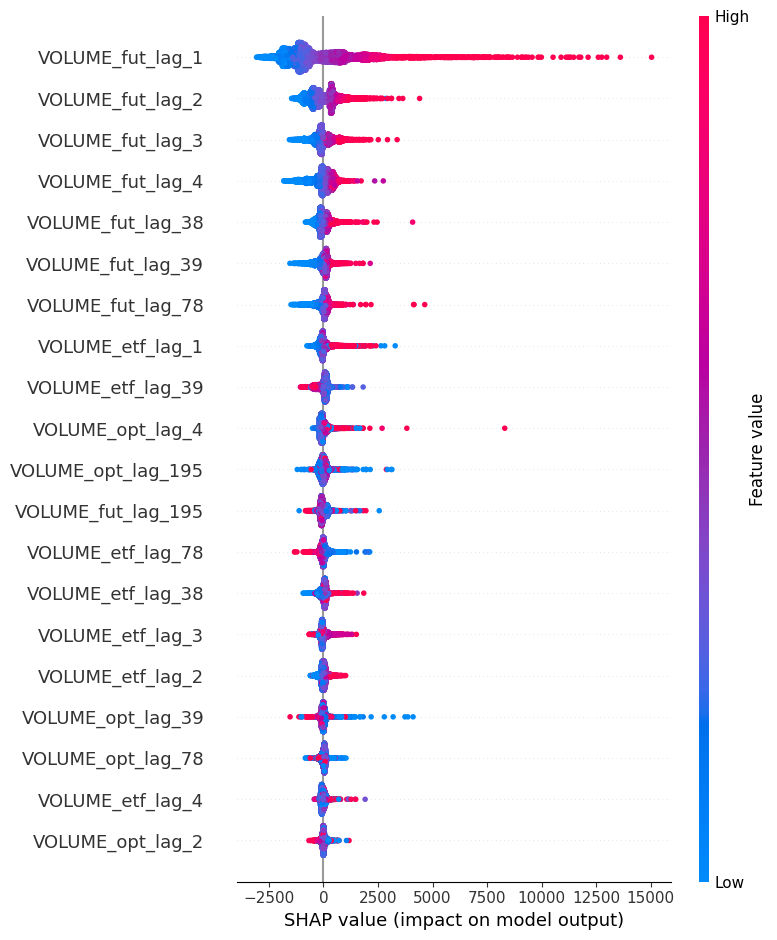

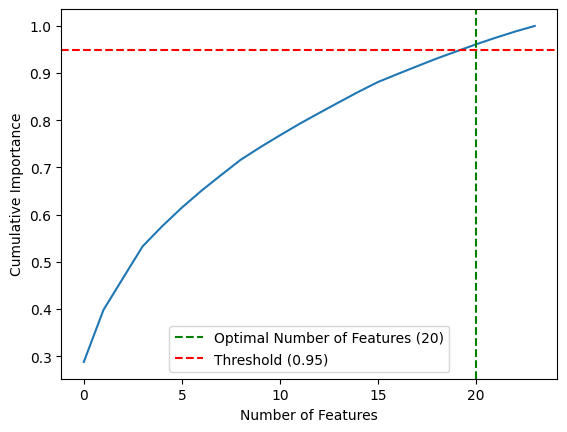

In [6]:
top_features = evaluate_feature_importance(
    df, train_indexes, lags_columns, TARGET, threshold=0.95, plot=PLOT_CHARTS
)

# Training

In [7]:
if not REMOVE_SEASONALITY:
    top_features = list(top_features) + ["hhmm"]
x_train, x_val, x_test = df.loc[train_indexes, top_features], df.loc[val_indexes, top_features], df.loc[test_indexes, top_features]
y_train, y_val, y_test = df.loc[train_indexes, TARGET], df.loc[val_indexes, TARGET], df.loc[test_indexes, TARGET]
metrics = {}

## Baseline Model

In [8]:
df = ts.copy()
df['VOLUME_fut_pred'] = df[TARGET].shift(1)

if REMOVE_SEASONALITY:
    df = restore_seasonality_ia(df)
else:
    df.loc[df['hhmm']==940, 'VOLUME_fut_pred'] = df.loc[df['hhmm']==940, TARGET].shift(1)
    df.loc[df['hhmm']==1600, 'VOLUME_fut_pred'] = df.loc[df['hhmm']==1600, TARGET].shift(1)

df_test = df.loc[test_indexes]

metrics= {
    'R2': r2_score(df_test[TARGET], df_test['VOLUME_fut_pred']),
    'MAE': mean_absolute_error(df_test[TARGET], df_test['VOLUME_fut_pred']),
    'MAPE': mean_absolute_percentage_error(df_test[TARGET], df_test['VOLUME_fut_pred'])}

metrics

{'R2': 0.6916495403944667,
 'MAE': 2570.732538071066,
 'MAPE': 0.21190262146108615}

## Simple Models

### Determine Models

In [9]:
xgb = XGBRegressor()
cat = CatBoostRegressor()
cfr = CascadeForestRegressor()
dnn = KerasRegressor(
    model=dnn,
    loss='mean_squared_error',
    optimizer='adam',
    # TODO: remove parameters below from here
    hid_layers_num=2,
    neurons_num_layer1=4,
    activation_layer1='relu',
    dropout_layer1=0,
    neurons_num_layer2=4,
    activation_layer2='relu',
    dropout_layer2=0,
    batch_size=32,
    epochs=3,
    verbose=0,
    random_seed=42,
)

### Models Parameters

In [10]:
models = {
    'xgboost': {
        'class': xgb, 
        'init_params': {
            'n_estimators': [100], 
            'max_depth': [3, 4], 
            'learning_rate': [0.1], 
            'verbosity': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {'verbose': False}
        },
    'catboost': {
        'class': cat, 
        'init_params': {
            'n_estimators': [100],
            'max_depth': [3, 4],
            'learning_rate': [0.1],
            'verbose': [0],
            'thread_count': [4],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
        },
    'cascadeforest': {
        'class': cfr,
        'init_params': {
            # 'n_estimators': [1],
            'n_trees': [100],
            'max_depth': [3, 4],
            # 'max_layers': [5],
            'use_predictor': [True],
            'predictor': ['lightgbm'],
            'verbose': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {}
    },
    'dnn': {
        'class': dnn,
        'init_params': {
            'hid_layers_num': [2],
            'neurons_num_layer1': [28, 32],
            'activation_layer1': ['relu'],
            'dropout_layer1': [0],
            'neurons_num_layer2': [28, 32],
            'activation_layer2': ['relu'],
            'dropout_layer2': [0],
            'batch_size': [32],
            'epochs': [100],
            'verbose': [0],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
    }
}

### Determine Metrics + Include Inverse Transform

In [11]:
# TODO: refactor code below
def custom_r2_metric(estimator, X, y_true):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    r2 = r2_score(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    return r2

def custom_mape_metric(estimator, X, y_true):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    return mape

# will use MAE as scorer (other metrics only for information)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

### GSCV

In [12]:
cv_metrics = pd.DataFrame()
sklearn_params = dict(
                scoring={
                    'MAE': mae_scorer, 
                    'R2': custom_r2_metric, 
                    'MAPE': custom_mape_metric
                },
                cv=TimeSeriesSplit(n_splits=FOLDS_NUM),
                refit='MAE',
                verbose=False,
                n_jobs=4,
            )
best_estimators = {}
for model_name, model_params in models.items():
    print(f"Training {model_name}...")
    gscv = GridSearchCV(
        model_params['class'],
        model_params['init_params'],
        **sklearn_params
    )
    gscv.fit(
        pd.concat([x_train, x_val]),
        np.ravel(pd.concat([y_train, y_val])),
        **model_params['fit_params']
    )
    
    cv_df = pd.DataFrame(gscv.cv_results_)[['params', 
                                            'mean_test_MAE', 'std_test_MAE', 
                                            'mean_test_MAPE', 'std_test_MAPE',
                                            'mean_test_R2', 'std_test_R2']]
    cv_df['mean_test_MAE'] = cv_df['mean_test_MAE'].abs()
    cv_df['model'] = model_name
    cv_metrics = pd.concat([cv_metrics, cv_df], ignore_index=True)
    print("Best mean test score:", gscv.best_score_)
    best_estimators[model_name] = gscv.best_estimator_
cv_metrics

Training xgboost...


2023-12-28 16:50:46.803276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-28 16:50:46.803299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-28 16:50:46.827832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-28 16:50:46.827859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-28 16:50:46.881834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Best mean test score: -2154.6324482773803
Training catboost...
Best mean test score: -2136.3690427885913
Training cascadeforest...
Best mean test score: -2226.9071732776656
Training dnn...


2023-12-28 16:51:11.872066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-28 16:51:11.872090: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-28 16:51:11.872110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dev-host-1.eng.sol.onetick.com): /proc/driver/nvidia/version does not exist
2023-12-28 16:51:11.872300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 16:51:11.874867: W tensorflow/stream_executor/platform/default/dso_loader

Best mean test score: -2239.399808861602


,params,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model
0,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 4, 'random_state': 42, 'verbosity': 0}",2154.632448,258.977427,0.205422,0.018484,0.803370,0.035118,xgboost
1,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'n_jobs': 4, 'random_state': 42, 'verbosity': 0}",2181.613878,254.659076,0.207708,0.018269,0.798080,0.033805,xgboost
2,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_seed': 42, 'thread_count': 4, 'verbose': 0}",2136.369043,272.132694,0.204286,0.020739,0.807070,0.033407,catboost
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_seed': 42, 'thread_count': 4, 'verbose': 0}",2138.669136,268.185286,0.204169,0.020280,0.807264,0.032202,catboost
4,"{'max_depth': 3, 'n_estimators': 1, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': True, 'verbose': 0}",2232.747718,262.165446,0.213307,0.017597,0.792157,0.036279,cascadeforest
5,"{'max_depth': 4, 'n_estimators': 1, 'n_jobs': 4, 'n_trees': 100, 'predictor': 'lightgbm', 'random_state': 42, 'use_predictor': True, 'verbose': 0}",2226.907173,262.304476,0.212760,0.016986,0.792707,0.034667,cascadeforest
6,"{'activation_layer1': 'relu', 'activation_layer2': 'relu', 'batch_size': 32, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 28, 'neurons_num_layer2': 28, 'random_seed': 42, 'verbose': 0}",2265.055164,283.693006,0.221286,0.032884,0.781034,0.081209,dnn
7,"{'activation_layer1': 'relu', 'activation_layer2': 'relu', 'batch_size': 32, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 28, 'neurons_num_layer2': 32, 'random_seed': 42, 'verbose': 0}",2255.385535,258.086305,0.221204,0.032175,0.786271,0.065278,dnn
8,"{'activation_layer1': 'relu', 'activation_layer2': 'relu', 'batch_size': 32, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 32, 'neurons_num_layer2': 28, 'random_seed': 42, 'verbose': 0}",2241.436586,276.478081,0.218398,0.030213,0.785263,0.075994,dnn
9,"{'activation_layer1': 'relu', 'activation_layer2': 'relu', 'batch_size': 32, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 32, 'neurons_num_layer2': 32, 'random_seed': 42, 'verbose': 0}",2239.399809,268.828457,0.218556,0.031278,0.788261,0.066335,dnn


### Evaluation On The Test Set

In [13]:
# TODO: refactor below and remove hard-coded values (package it into a function?)
for model_name, estimator in best_estimators.items():
    y_pred = pd.DataFrame(estimator.predict(x_test), index=x_test.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    
    tdf_test.dropna(inplace=True)
    r2 = r2_score(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    mae = mean_absolute_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    
    metrics[model_name] = {
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }
metrics

{'R2': 0.6916495403944667,
 'MAE': 2570.732538071066,
 'MAPE': 0.21190262146108615,
 'xgboost': {'R2': 0.7621187681177538,
  'MAE': 2217.7651410592653,
  'MAPE': 0.18798066651512296},
 'catboost': {'R2': 0.7655673914457107,
  'MAE': 2212.7026699845546,
  'MAPE': 0.1868531159603609},
 'cascadeforest': {'R2': 0.7536905704772142,
  'MAE': 2266.504280728531,
  'MAPE': 0.1912464432495631},
 'dnn': {'R2': 0.768390451864041,
  'MAE': 2222.212011000449,
  'MAPE': 0.18769570140853256}}

## Ensemble Models

In [14]:
concat_x = pd.concat([x_train, x_val])
concat_y = pd.concat([y_train, y_val])

### Grid Search Parameters

In [15]:
model_gs_params = {
    "xgboost": {
        "max_depth": [3, 4],
        "learning_rate": [0.09, 0.1],
        "early_stopping_rounds": [30],
        'verbosity': [0],
        'n_jobs': [4],
        'random_state': [42]
    },
    "catboost": {
        "n_estimators": [100],
        "max_depth": [3, 4],
        "learning_rate": [0.09, 0.1],
        "early_stopping_rounds": [30],
        "loss_function": ["RMSE"],
        "custom_metric": ["MAE"],
        "use_best_model": [True],
        "verbose": [0],
        'thread_count': [4],
        "random_seed": [42],
    },
}

### CV Parameters

In [16]:
def get_model_cv_params(model_type, params, concat_x, concat_y):
    model_cv_params = {
        "xgboost": {
            "dtrain": DMatrix(concat_x, concat_y),
            "folds": TimeSeriesSplit(n_splits=FOLDS_NUM),
            "params": params,
            "cv_function": xgb_cv,
        },
        "catboost": {
            "pool": Pool(concat_x, concat_y),
            "fold_count": FOLDS_NUM,
            "cv_function": cat_cv,
            "params": params,
        },
    }
    return model_cv_params[model_type]


def get_general_cv_params(model_type, params, cb_instance=None):
    general_cv_params = {
        "xgboost": {
            "num_boost_round": 100,
            "early_stopping_rounds": params["early_stopping_rounds"],
            "metrics": ["rmse", "mae"],
            "as_pandas": True,
            "shuffle": False,
            "callbacks": [cb_instance],
        },
        "catboost": {
            "early_stopping_rounds": params["early_stopping_rounds"],
            "shuffle": False,
            "type": "TimeSeries",
            "return_models": True,
            "plot": False,
            "logging_level": "Silent",
        },
    }
    return general_cv_params[model_type]

### GSCV

In [17]:
# auxiliary functions
def compose_result(model_type, params, cv_results, cb_instance=None):
    if model_type == "xgboost":
        result = {
            "cv_results": cv_results,
            "cv_models": cb_instance.cvboosters,
        }
    if model_type == "catboost":
        result = {"cv_results": cv_results[0], "cv_models": cv_results[1]}
    result["params"] = params
    return result


def run_grid_search(model_type, params, concat_x, concat_y, cb_instance=None):
    model_cv_params = get_model_cv_params(model_type, params, concat_x, concat_y)
    general_cv_params = get_general_cv_params(model_type, params, cb_instance)
    cv_function = model_cv_params.pop("cv_function")
    cv_results = cv_function(**model_cv_params, **general_cv_params)
    result = compose_result(model_type, params, cv_results, cb_instance)
    return result

In [18]:
# run gscv
models_results = {}
for model_type in model_gs_params.keys():
    print(f"Training {model_type}...\n")
    if model_type == "xgboost":
        cb_instance = XGBSaveFoldsModels()
    param_grid = model_gs_params[model_type]
    model_results = Parallel(n_jobs=4, backend="loky")(
        delayed(run_grid_search)(model_type, params, concat_x, concat_y, cb_instance)
        for params in ParameterGrid(param_grid)
    )
    model_results = {str(result["params"]): result for result in model_results}
    models_results[model_type] = model_results

# best results and folds-models for each model type
best_vals = {}
for model_type in model_gs_params.keys():
    best_mae, best_vals[model_type] = np.inf, None
    for result in models_results[model_type].values():
        result["cv_results"].columns = result["cv_results"].columns.str.upper()
        current_mae = result["cv_results"]["TEST-MAE-MEAN"].min()
        if current_mae < best_mae:
            best_mae, best_vals[model_type] = current_mae, result
    print(
        f"Model {model_type} best MAE:",
        best_mae,
        f"with params: {best_vals[model_type]['params']}",
    )

Training xgboost...

Training catboost...

Model xgboost best MAE: 2146.7524373521364 with params: {'early_stopping_rounds': 30, 'learning_rate': 0.09, 'max_depth': 3, 'n_jobs': 4, 'random_state': 42, 'verbosity': 0}
Model catboost best MAE: 2136.059267667506 with params: {'custom_metric': 'MAE', 'early_stopping_rounds': 30, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'max_depth': 3, 'n_estimators': 100, 'random_seed': 42, 'thread_count': 4, 'use_best_model': True, 'verbose': 0}


### Evaluation On The Test Set

In [ ]:
# TODO: check 2 approaches for walk-forward validation: expand train window and fixed train window